In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
from pathlib import Path
import pandas as pd
from statsmodels.api import OLS
import matplotlib.pyplot as plt
import seaborn

In [3]:
plt.style.use('fivethirtyeight')
%matplotlib inline

In [4]:
data_path = Path('..', '00_data')

In [5]:
ff_factor = 'F-F_Research_Data_5_Factors_2x3_daily'

with pd.HDFStore(data_path / 'risk_factors.h5') as store:
    ff_data = store.get(ff_factor).tz_localize('UTC')

In [6]:
N_LONGS = 200
N_SHORTS = 0
VOL_SCREEN = 1000

In [7]:
id = f'_long_{N_LONGS}_short_{N_SHORTS}_vol_{VOL_SCREEN}'
with pd.HDFStore(data_path / 'backtests.h5') as store:
    pf_returns = store['returns' + id].mul(100).to_frame('Portfolio')

In [8]:
data = pf_returns.join(ff_data, how='inner')

In [9]:
def lin_reg_results(y, X):
    model = OLS(endog=y, exog=X.assign(alpha=1)).fit(cov_type='HAC', cov_kwds={'maxlags': 1})
    return (model.params.to_frame('coef')
            .join(model.conf_int().rename(columns={0: 'lower', 1: 'upper'}))
           .loc[:, ['lower', 'coef', 'upper']]
           .drop('RF'))

In [10]:
factor_exposures = (data.groupby(data.index.year)
                    .apply(lambda x: lin_reg_results(y=x.Portfolio, X=x.iloc[:, 1:]))
                    .swaplevel(0, 1))
factor_exposures.index.names = ['Factor', 'Year']

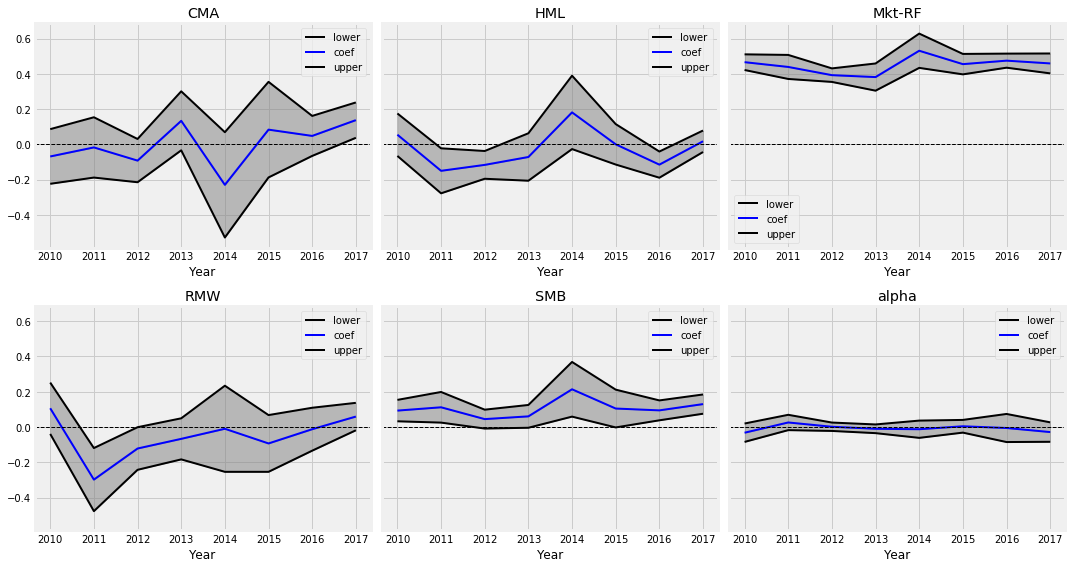

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharey='all')
axes = axes.flatten()

for i, (factor, exposure) in enumerate(factor_exposures.groupby(level='Factor')):
    df = exposure.reset_index('Factor', drop=True)
    ax = df.plot(title=factor, ax=axes[i], lw=2, color=['k', 'b', 'k'])
    ax.fill_between(x=df.index, y1=df.lower, y2=df.coef, alpha=0.5, color='grey')
    ax.fill_between(x=df.index, y1=df.coef, y2=df.upper, alpha=0.5, color='grey')
    ax.axhline(0, lw=1, ls='--', color='k')
    
fig.tight_layout();

In [13]:
def lin_reg(y, X, T):
    model = OLS(endog=y, exog=X.assign(alpha=1))
    result = model.fit(cov_type='HAC',
                       cov_kwds={'maxlags': 1})
    coefs = result.params.to_frame('coef')
    ci = result.conf_int().rename(columns={0: 'lower', 1: 'upper'})
    return (coefs.join(ci)[['lower', 'coef', 'upper']]
            .drop('RF')
            .assign(date=T)
            .set_index('date', append=True))

In [14]:
window = 252
rolling_exposure = pd.DataFrame()
for T in range(window, len(data)):
    df = data.iloc[T-window:T]
    rolling_exposure = rolling_exposure.append(lin_reg(df.Portfolio,
                                                       df.iloc[:, 1:],
                                                       T=data.index[T]))
rolling_exposure.index.names = ['Factor', 'Year']

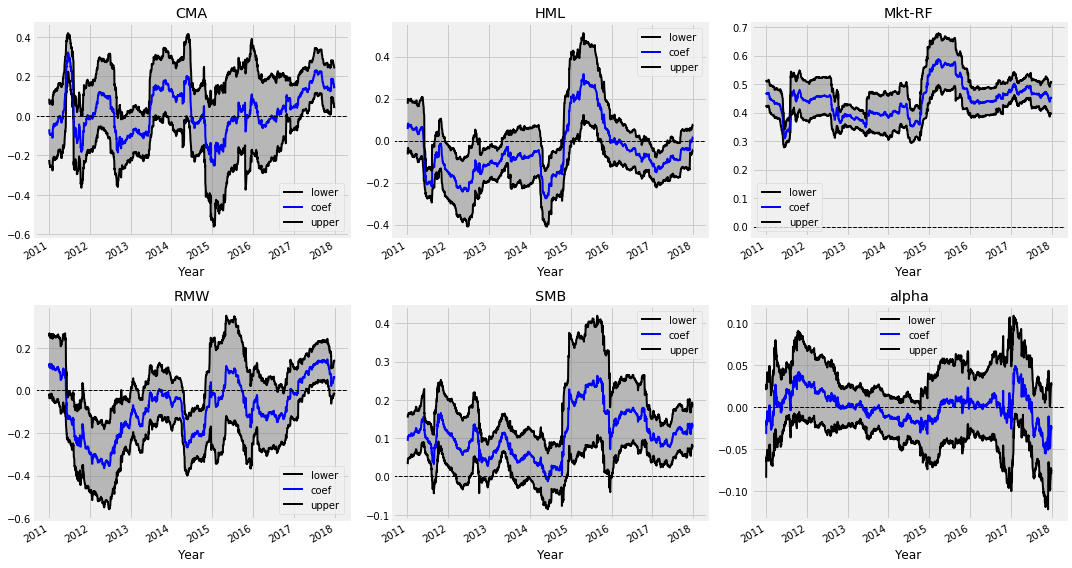

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, (factor, exposure) in enumerate(rolling_exposure.groupby(level='Factor')):
    df = exposure.reset_index('Factor', drop=True)
    ax = df.plot(title=factor, ax=axes[i], lw=2, color=['k', 'b', 'k'])
    ax.fill_between(x=df.index, y1=df.lower, y2=df.coef, alpha=0.5, color='grey')
    ax.fill_between(x=df.index, y1=df.coef, y2=df.upper, alpha=0.5, color='grey')
    ax.axhline(0, lw=1, ls='--', color='k')
    
fig.tight_layout();